In [1]:
using LinearAlgebra, Kronecker, Random, BlockDiagonals, PyPlot
rc("axes.spines", top=false, right=false)

In [2]:
eye(n) = Diagonal(I, n)
vec(X) = vcat(X...)

vec (generic function with 1 method)

In [3]:
n = 4 # number of dims
i = 0.25 # kgm^2, 
b = 0.2 # kgm^2/s
ta = 0.03 # s
te = 0.04 # s
L0 = 0.35 # m

bu = 1 / (ta * te * i)
α1 = bu * b
α2 = 1/(ta * te) + (1/ta + 1/te) * b/i
α3 = b/i + 1/ta + 1/te

A = [zeros(3) eye(3); -[0, α1, α2, α3]']
B = [zeros(3); bu]
C = [eye(3) zeros(3)]
D = Diagonal([1e-3, 1e-2, 5e-2])

Y = 0.02 * B
G = 0.03 * eye(n)

Q = Diagonal([1.0, 0.01, 0, 0]) 
R = 0.0001
U = Diagonal([1.0, 0.1, 0.01, 0]);

In [4]:
maxiter = 1000
eps = 1e-8

# initialize
L = rand(n)' # Feedback gains
K = rand(n, 3) # Kalman gains
I2n = eye(2n)

for i in 1:maxiter
    Ā = [A-B*L B*L; zeros(size(A)) (A-K*C)]
    Ȳ = [-ones(2) ones(2)] ⊗ (Y*L) 
    Ḡ = [G zeros(size(K)); G (-K*D)]
    V = BlockDiagonal([Q, U]) + [1 -1; -1 1] ⊗ (L'* R * L)
    
    # update S, P
    S = -reshape((I2n' ⊗ (Ā)' +  (Ā)' ⊗ I2n + (Ȳ)' ⊗ (Ȳ)') \ vec(V), (2n, 2n))
    P = -reshape((I2n' ⊗ Ā +  Ā ⊗ I2n + Ȳ ⊗  Ȳ) \ vec(Ḡ * (Ḡ)'), (2n, 2n))

    # update K, L
    P22 = P[n+1:2n, n+1:2n]
    S11 = S[1:n, 1:n]
    S22 = S[n+1:2n, n+1:2n]

    Ktm1 = copy(K)
    Ltm1 = copy(L)

    K = P22 * C' / (D * D')
    L = (R + Y' * (S11 + S22) * Y) \ B' * S11
    if sum(abs.(K - Ktm1)) < eps && sum(abs.(L - Ltm1)) < eps
        break
    end
end

In [5]:
dt = 0.001 # sec
T = 2.0 # sec
nt = round(Int, T/dt)
Xa = zeros(4, nt)
ua = zeros(nt)
Xa[1, 1] = -0.5 # m; initial position (target position is zero)

for k=1:nt-1
    ua[k] = -L * Xa[:, k]
    Xa[:, k+1] = Xa[:,k] + (A * Xa[:,k] + B * ua[k]) * dt
end

In [6]:
sqrtdt = √dt
nsim = 10
XSimAll = zeros(nsim, 4, nt)
uSimAll = zeros(nsim, nt)
for i in 1:nsim
    XSim = zeros(4, nt)
    Xhat = zeros(4, nt)
    u = zeros(nt)
    XSim[1, 1] = -0.5 # m; initial position (target position is zero)
    Xhat[1, 1] = XSim[1, 1]
    
    for k=1:nt-1
        u[k] = -L * Xhat[:, k]
        XSim[:, k+1] = XSim[:,k] + (A * XSim[:,k] + B * u[k]) * dt + sqrtdt * (Y * u[k] * randn() + G * randn(n))
        dy = C * XSim[:,k] * dt + D * sqrtdt * randn(n-1)
        Xhat[:, k+1] = Xhat[:,k] + (A * Xhat[:,k] + B * u[k]) * dt + K * (dy - C * Xhat[:,k] * dt)
    end
    XSimAll[i,:,:] = XSim
    uSimAll[i, :] = u
end

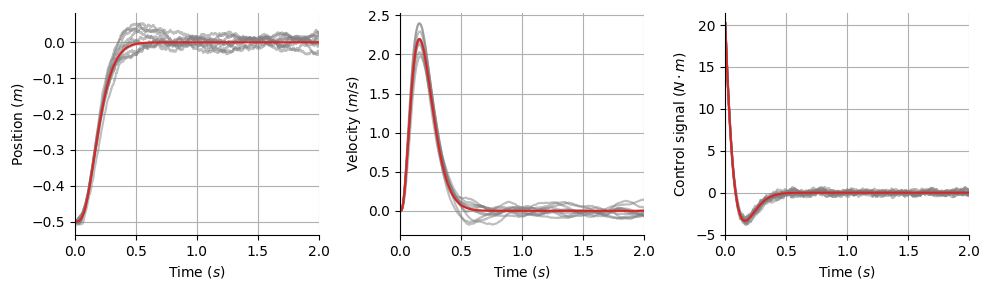

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall C:\Users\yamta\.julia\packages\PyCall\3fwVL\src\numpy.jl:67


In [7]:
tarray = (1:nt) * dt
label = [L"Position ($m$)", L"Velocity ($m/s$)", L"Acceleration ($m/s^2$)", L"Jerk ($m/s^3$)"]
figure(figsize=(10, 3))
for i in 1:2
    subplot(1,3,i)
    plot(tarray, XSimAll[:,i,:]', "tab:gray", alpha=0.5)
    plot(tarray, Xa[i,:], "tab:red")
    ylabel(label[i]); xlabel(L"Time ($s$)"); xlim(0, T); grid()
end
subplot(1,3,3)
plot(tarray, uSimAll', "tab:gray", alpha=0.5)
plot(tarray, ua, "tab:red")
ylabel(L"Control signal ($N\cdot m$)"); xlabel(L"Time ($s$)"); xlim(0, T); grid()

tight_layout()

In [8]:
T = 1.0   # sec
Ttj = 0.4 # target jumping timing (sec)
nt = round(Int, T/dt)
ntj = round(Int, Ttj/dt)
tj_dist = 0.1; # target jump distance

In [9]:
Xtj = zeros(4, nt)
utj = zeros(nt)
Xtj[1, 1] = -0.5 # m; initial position (target position is zero)

for k=1:nt-1
    if k == ntj
        Xtj[1,k] -= tj_dist # When k == ntj, target jumpさせる（実際には現在の位置をずらす）
    end
    utj[k] = -L * Xtj[:, k]
    Xtj[:, k+1] = Xtj[:,k] + (A * Xtj[:,k] + B * utj[k]) * dt
end

Xtj[1, 1:ntj-1] .-= tj_dist;

In [10]:
XtjAll = zeros(nsim, 4, nt)
utjAll = zeros(nsim, nt)
for i in 1:nsim
    XSim = zeros(4, nt)
    Xhat = zeros(4, nt)
    u = zeros(nt)
    XSim[1, 1] = -0.5 # m; initial position (target position is zero)
    Xhat[1, 1] = XSim[1, 1]
    
    for k=1:nt-1
        if k == ntj
            XSim[1,k] -= tj_dist
            Xhat[1,k] -= tj_dist
        end
        u[k] = -L * Xhat[:, k]
        XSim[:, k+1] = XSim[:,k] + (A * XSim[:,k] + B * u[k]) * dt + sqrtdt * (Y * u[k] * randn() + G * randn(n))
        dy = C * XSim[:,k] * dt + D * sqrtdt * randn(n-1)
        Xhat[:, k+1] = Xhat[:,k] + (A * Xhat[:,k] + B * u[k]) * dt + K * (dy - C * Xhat[:,k] * dt)
    end
    XtjAll[i,:,:] = XSim
    utjAll[i, :] = u
end

XtjAll[:, 1, 1:ntj-1] .-= tj_dist;

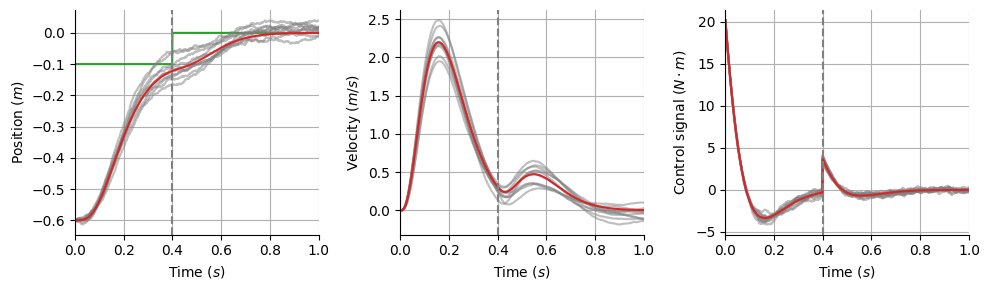

In [11]:
tarray = (1:nt) * dt
target_pos = zeros(nt)
target_pos[1:ntj-1] .-= tj_dist; 

figure(figsize=(10, 3))
for i in 1:2
    subplot(1,3,i)
    if i == 1
        plot(tarray, target_pos, "tab:green")
    end
    plot(tarray, XtjAll[:,i,:]', "tab:gray", alpha=0.5)
    plot(tarray, Xtj[i,:], "tab:red")
    axvline(x=Ttj, color="gray", linestyle="dashed")
    ylabel(label[i]); xlabel(L"Time ($s$)"); xlim(0, T); grid()
     
end
subplot(1,3,3)
plot(tarray, utjAll', "tab:gray", alpha=0.5)
plot(tarray, utj, "tab:red")
axvline(x=Ttj, color="gray", linestyle="dashed")
ylabel(L"Control signal ($N\cdot m$)"); xlabel(L"Time ($s$)"); xlim(0, T); grid()

tight_layout()